In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

import warnings
warnings.filterwarnings("ignore")

2025-08-15 06:59:46.317603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755241186.586435      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755241186.655264      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ==========================
# CONFIG
# ==========================
DATASET_PATH = "/kaggle/input/dataset"  # Kaggle dataset
SIZE = 224  # VGG16 default input size
TEST_SPLIT = 0.2
VAL_SPLIT = 0.2
RANDOM_STATE = 42

In [3]:
# ==========================
# LOAD IMAGES & LABELS
# ==========================
images = []
labels = []

for class_dir in glob.glob(os.path.join(DATASET_PATH, "*")):
    if not os.path.isdir(class_dir):
        continue
    label = os.path.basename(class_dir)
    for img_path in glob.glob(os.path.join(class_dir, "*.jpg")):
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [4]:
# ==========================
# ENCODE LABELS
# ==========================
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [5]:
# ==========================
# SPLIT DATA
# ==========================
x_train_full, x_test, y_train_full, y_test = train_test_split(
    images, labels_encoded,
    test_size=TEST_SPLIT,
    stratify=labels_encoded,
    random_state=RANDOM_STATE
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full,
    test_size=VAL_SPLIT,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

In [6]:
# ==========================
# PREPROCESS FOR VGG16
# ==========================
x_train = preprocess_input(x_train.astype('float32'))
x_val = preprocess_input(x_val.astype('float32'))
x_test = preprocess_input(x_test.astype('float32'))

In [7]:
# ==========================
# VGG16 FEATURE EXTRACTION
# ==========================
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
for layer in VGG_model.layers:
    layer.trainable = False

print("Extracting features with VGG16...")

X_train_features = VGG_model.predict(x_train, verbose=1)
X_val_features = VGG_model.predict(x_val, verbose=1)
X_test_features = VGG_model.predict(x_test, verbose=1)

2025-08-15 07:02:01.266084: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting features with VGG16...
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


In [8]:
# Flatten features into 2D (samples, features)
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_val_features = X_val_features.reshape(X_val_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

In [9]:
# ==========================
# TRAIN XGBOOST
# ==========================
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False
)

xgb_model.fit(
    X_train_features, y_train,
    eval_set=[(X_val_features, y_val)],
    early_stopping_rounds=20,
    verbose=True
)

[0]	validation_0-mlogloss:1.19278
[1]	validation_0-mlogloss:0.97651
[2]	validation_0-mlogloss:0.82502
[3]	validation_0-mlogloss:0.72282
[4]	validation_0-mlogloss:0.65211
[5]	validation_0-mlogloss:0.57479
[6]	validation_0-mlogloss:0.51442
[7]	validation_0-mlogloss:0.47151
[8]	validation_0-mlogloss:0.43607
[9]	validation_0-mlogloss:0.41250
[10]	validation_0-mlogloss:0.39541
[11]	validation_0-mlogloss:0.36331
[12]	validation_0-mlogloss:0.35280
[13]	validation_0-mlogloss:0.33838
[14]	validation_0-mlogloss:0.32020
[15]	validation_0-mlogloss:0.31794
[16]	validation_0-mlogloss:0.31189
[17]	validation_0-mlogloss:0.29784
[18]	validation_0-mlogloss:0.29691
[19]	validation_0-mlogloss:0.29305
[20]	validation_0-mlogloss:0.28762
[21]	validation_0-mlogloss:0.28380
[22]	validation_0-mlogloss:0.27833
[23]	validation_0-mlogloss:0.27922
[24]	validation_0-mlogloss:0.27686
[25]	validation_0-mlogloss:0.27849
[26]	validation_0-mlogloss:0.27567
[27]	validation_0-mlogloss:0.27216
[28]	validation_0-mlogloss:0.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)


Overall Accuracy: 0.9230769230769231

Classification Report:
              precision    recall  f1-score   support

         cat       0.95      0.95      0.95        21
         cow       0.94      0.85      0.89        20
         dog       0.86      0.90      0.88        21
        lamb       0.87      0.91      0.89        22
       zebra       1.00      1.00      1.00        20

    accuracy                           0.92       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.92      0.92      0.92       104



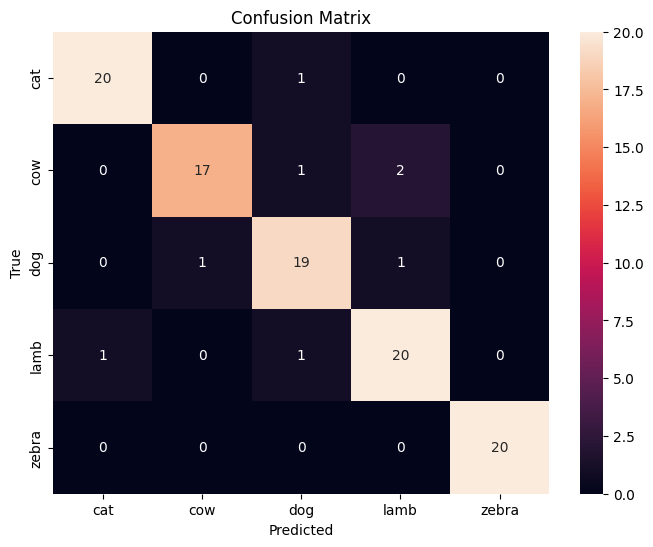

In [10]:
# ==========================
# PREDICT & EVALUATE
# ==========================
predictions = xgb_model.predict(X_test_features)

accuracy = metrics.accuracy_score(y_test, predictions)
print("\nOverall Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=le.classes_))

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [11]:
# ==========================
# ERROR ANALYSIS
# ==========================
accuracy = metrics.accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average=None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)

print("\n===== Overall Metrics =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision_score(y_test, predictions, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test, predictions, average='macro'):.4f}")
print(f"Macro F1-score: {f1_score(y_test, predictions, average='macro'):.4f}")
print(f"Weighted Precision: {precision_score(y_test, predictions, average='weighted'):.4f}")
print(f"Weighted Recall: {recall_score(y_test, predictions, average='weighted'):.4f}")
print(f"Weighted F1-score: {f1_score(y_test, predictions, average='weighted'):.4f}")

print("\n===== Classification Report =====")
print(classification_report(y_test, predictions, target_names=le.classes_))


===== Overall Metrics =====
Accuracy: 0.9231
Macro Precision: 0.9260
Macro Recall: 0.9232
Macro F1-score: 0.9239
Weighted Precision: 0.9246
Weighted Recall: 0.9231
Weighted F1-score: 0.9232

===== Classification Report =====
              precision    recall  f1-score   support

         cat       0.95      0.95      0.95        21
         cow       0.94      0.85      0.89        20
         dog       0.86      0.90      0.88        21
        lamb       0.87      0.91      0.89        22
       zebra       1.00      1.00      1.00        20

    accuracy                           0.92       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.92      0.92      0.92       104



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step

Random Image Prediction:
Prediction: lamb
Actual: lamb


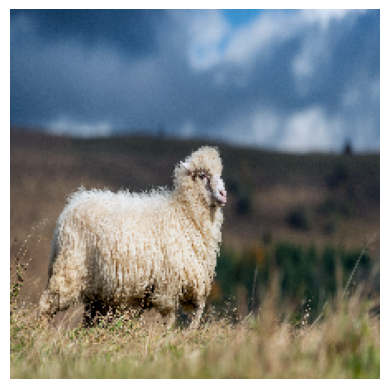

In [13]:
# ==========================
# RANDOM IMAGE CHECK
# ==========================
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow((img + 103.939)[:,:,::-1]/255)  # Roughly reverse preprocess_input for visualization
plt.axis("off")
input_img = np.expand_dims(img, axis=0)
input_features = VGG_model.predict(input_img)
input_features = input_features.reshape(input_features.shape[0], -1)
pred_class = xgb_model.predict(input_features)[0]
pred_label = le.inverse_transform([pred_class])[0]

print("\nRandom Image Prediction:")
print("Prediction:", pred_label)
print("Actual:", le.inverse_transform([y_test[n]])[0])

# SVM with RBF Kernel

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
# Encode labels (same for XGBoost and SVM)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import random

In [17]:
# Flatten VGG16 features for SVM
X_train_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_val_flat = X_val_features.reshape(X_val_features.shape[0], -1)
X_test_flat = X_test_features.reshape(X_test_features.shape[0], -1)

In [18]:
# -----------------------------
# Train SVM with RBF kernel
# -----------------------------
svm_rbf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

print("Training SVM with RBF kernel...")
svm_rbf.fit(X_train_flat, y_train_encoded)

Training SVM with RBF kernel...


SVC(C=10, random_state=42)

In [19]:
# Predictions
val_preds_svm = svm_rbf.predict(X_val_flat)
test_preds_svm = svm_rbf.predict(X_test_flat)

In [20]:
# Accuracy scores
val_acc_svm = accuracy_score(y_val_encoded, val_preds_svm)
test_acc_svm = accuracy_score(y_test_encoded, test_preds_svm)

print(f"Validation Accuracy (SVM RBF): {val_acc_svm:.4f}")
print(f"Test Accuracy (SVM RBF): {test_acc_svm:.4f}")

Validation Accuracy (SVM RBF): 0.9880
Test Accuracy (SVM RBF): 0.9712


In [21]:
# Classification report
target_names = [str(c) for c in label_encoder.classes_]

print("\nClassification Report (Test Data - SVM RBF):")
print(classification_report(y_test_encoded, test_preds_svm, target_names=target_names))


Classification Report (Test Data - SVM RBF):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.90      0.95        20
           2       0.95      1.00      0.98        21
           3       0.91      0.95      0.93        22
           4       1.00      1.00      1.00        20

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104



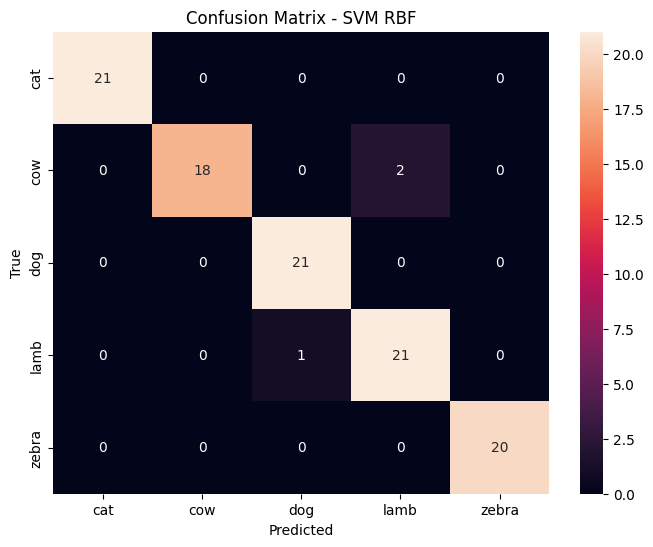

In [24]:
# Make predictions for SVM RBF
svm_predictions = svm_rbf.predict(X_test_flat)

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM RBF")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step

Random Image Prediction (SVM RBF):
Prediction: dog
Actual: dog


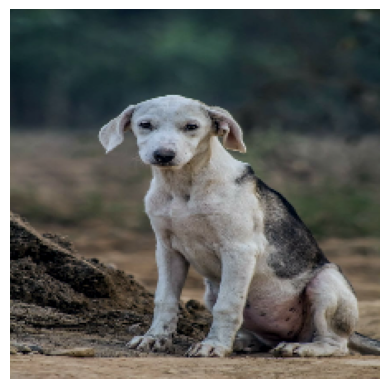

In [27]:
# ==========================
# RANDOM IMAGE CHECK - SVM (RBF)
# ==========================
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]

# Reverse preprocess_input for display
plt.imshow((img + 103.939)[:, :, ::-1] / 255)  
plt.axis("off")

# Prepare the image for SVM prediction
input_img = np.expand_dims(img, axis=0)
input_features = VGG_model.predict(input_img)
input_features = input_features.reshape(input_features.shape[0], -1)

# Predict using SVM RBF
pred_class = svm_rbf.predict(input_features)[0]
pred_label = le.inverse_transform([pred_class])[0]

print("\nRandom Image Prediction (SVM RBF):")
print("Prediction:", pred_label)
print("Actual:", le.inverse_transform([y_test_encoded[n]])[0])